In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path

import precision_functions as prefun

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

### Constants

In [5]:
EVENT = "rastoc:stillness-position-lost"
TRIAL_TAG = 'validation-stimulus' #Opcion: "fixation-stimulus"  # Es el momento donde aparece la cruz de fijacion
FIRST_SAMPLE = 500
MAX_VAR = 75
MAX_PLOTS = None
VERBOSE = False
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
LOAD_PATH = str(ALL_FILES_RAW[0])
LOAD_INFO = LOAD_PATH.split('/')[1].split('_')


# print("All files:",ALL_FILES_RAW, end='\n\n')
# print(f"""File loaded:
# {LOAD_INFO[0]}
# {LOAD_INFO[1]}
# {LOAD_INFO[2]}
# {LOAD_INFO[3]}
# {LOAD_INFO[4].split('.')[0]}""")


In [17]:
for i in ALL_FILES_RAW:
    df = pd.read_csv(i)
    df_res = prefun.calculate_and_plot_errors(df, 
                                   TRIAL_TAG,
                                   first_sample=FIRST_SAMPLE,
                                   max_var=MAX_VAR,
                                   max_plots=MAX_PLOTS, 
                                   verbose=VERBOSE)

    SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
    print(f'Saved: {i}')
    df_res.to_csv(i, index=False)

KeyError: 'response'

### Data load

In [6]:
print(LOAD_PATH)
df = pd.read_csv(LOAD_PATH)
df.head(5)

raw_data/juan_webcam3_computer3_chrome_ubuntu.csv


,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,load_time,success,jspsych_start_time,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,stimulus,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,session-id,validation-id,tracked-trial-id,trial-tag,start-x,start-y,events
0,175309.0,"{""name-id"":""Juan "",""webcam-id"":""3"",""computer-i...",survey-html-form,0,175315,0.0-0.0,71,1,2023-02-06 18:33:39,11bc6a1935539ad33182170036aa5e75,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,webgazer-init-camera,1,216823,0.0-1.0,71,1,2023-02-06 18:33:39,11bc6a1935539ad33182170036aa5e75,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,3295.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,fullscreen,2,219801,0.0-2.0,71,1,2023-02-06 18:33:39,11bc6a1935539ad33182170036aa5e75,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,events-tracking-start,3,219802,0.0-3.0,71,1,2023-02-06 18:33:39,11bc6a1935539ad33182170036aa5e75,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,2023-02-06T18:33:44.891Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58059.0,NaN,virtual-chinrest,4,277862,0.0-4.0,71,1,2023-02-06 18:33:39,11bc6a1935539ad33182170036aa5e75,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,85.6,53.98,352.0,4.11,568.55,8.610123,40.88211,46.964308,26.417423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check rastoc events

In [ ]:
events  = prefun.get_rastoc_events(df, EVENT)
print("len(events):", len(events))

### Precision experiment analysis

k: 0
k: 1
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
k: 45
k: 46
k: 47
k: 48
k: 49
k: 50
k: 51
k: 52
k: 53
k: 54
k: 55
k: 56
k: 57
k: 58
k: 59
k: 60
k: 61
k: 62
k: 63
k: 64
k: 65
k: 66
k: 67
k: 68
k: 69
k: 70
k: 71
k: 72
k: 73
k: 74
k: 75
k: 76
k: 77
k: 78
k: 79
k: 80
k: 81
k: 82
k: 83
k: 84
k: 85
k: 86
k: 87
k: 88
k: 89
k: 90
k: 91
k: 92
k: 93
k: 94
k: 95
k: 96
k: 97
k: 98
k: 99
k: 100
k: 101
k: 102
k: 103
k: 104
k: 105
k: 106
k: 107
k: 108
k: 109
k: 110
k: 111
k: 112
k: 113
k: 114
k: 115
k: 116
k: 117
k: 118
k: 119
k: 120
k: 121
k: 122
k: 123
k: 124
k: 125
k: 126
k: 127
k: 128
k: 129
k: 130
k: 131
k: 132
k: 133
k: 134
k: 135
k: 136
k: 137
k: 138
k: 139
k: 140
k: 141
k: 142
k: 143
k: 144
k: 145
k: 146
k: 147
k: 148
k: 149
k: 150
k: 151
k: 152
k: 153
k: 154
k: 155
k: 156
k: 157
k: 1

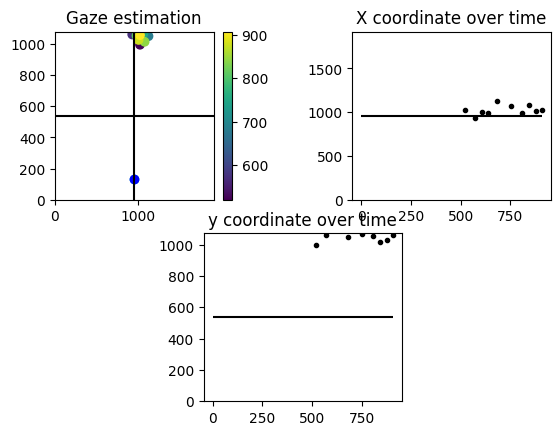

In [7]:
df_res = prefun.calculate_and_plot_errors(df, 
                                   TRIAL_TAG,
                                   first_sample=FIRST_SAMPLE,
                                   max_var=MAX_VAR,
                                   max_plots=MAX_PLOTS, 
                                   verbose=VERBOSE)

print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")

### Analysis

In [8]:
print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")
print(f"Cantidad de NaNs: {df_res['total_errors_pxs_mean'].isna().sum()}")


Error: 252.42 +- 153.45
Cantidad de NaNs: 371


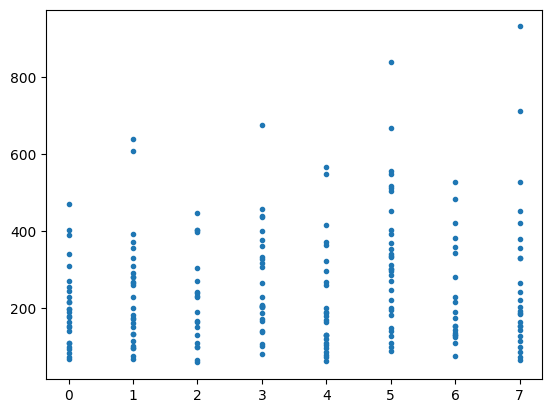

In [10]:
plt.plot((df_res['trials']-1)%8,df_res['total_errors_pxs_mean'],'.')

In [11]:
# plt.plot((df_res['trials']-1)%8,df_res['total_errors_pxs_mean'],'.')

sns.regplot(df_res, x=(df_res['trials']-1)%8, y='total_errors_pxs_mean')

# a = (df_res['trials']-1)%8
# sns.boxplot(data=df_res, x=a, y='total_errors_pxs_mean')

/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Must pass `data` if using named variables.

In [12]:
a = (df_res['trials']-1)%8
# sns.regplot(df_res, x=a, y='total_errors_pxs_mean')
ax = sns.scatterplot(df_res,  x=a, y='total_errors_pxs_mean', hue='presented_point')
ax.legend(bbox_to_anchor=(1.3, 1.3))

ValueError: Could not interpret value `total_errors_pxs_mean` for parameter `y`

In [ ]:
center_x = df[df["trial-tag"] == TRIAL_TAG]["center_x"].iloc[0]
center_y = df[df["trial-tag"] == TRIAL_TAG]["center_y"].iloc[0]

df_res['presented_distance'] = df_res['presented_point'].apply(lambda x: np.sqrt((x[0] - center_x)**2 + (x[1] - center_y)**2))

df_res.groupby('presented_distance').mean()



In [ ]:
df_res[['presented_point_x','presented_point_y']] = pd.DataFrame(df_res['presented_point'].tolist())

In [ ]:
points_position_dict = dict(zip(df_res['presented_point'].unique(), range(1,10)))

df_res['presented_point_index'] = df_res["presented_point"].map(points_position_dict)

In [ ]:
df_res[['presented_point_index', 'presented_point']].head(20)

In [ ]:
# plt.plot(df_res['trials'],df_res['total_errors_pxs_mean'],'.')
sns.regplot(df_res, x='trials', y='total_errors_pxs_mean')

In [9]:
ALL_FILES_ANALYZED = list(Path("./analyzed").glob("*.csv"))
ALL_FILES_ANALYZED

prefun.evaluate_experiment_instances(ALL_FILES_ANALYZED)

analyzed/analyzed_gus_webcam4_computer_3_chrome_ubuntu.csv
Error: 154.81 +- 87.27
Sampling rate: 23.57 +- 7.06
---


In [ ]:
df_res['first_sample'].iloc[0]

### Save

In [ ]:
SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
print(f'Saved: {SAVE_PATH}')
df_res.to_csv(SAVE_PATH, index=False)

### Cosas

In [ ]:

df = pd.read_csv('/home/gus/Downloads/antisacadas_91.csv')
df.head(5)

In [ ]:
df.columns

In [1]:
# df[~df['webgazer_data'].isna()]['webgazer_data']

# Antisacadas
df_antisacadas = df.query("not webgazer_data.isnull() and typeOfSaccade == 'antisaccade'")

webgazer_data_antisacadas = df_antisacadas['webgazer_data'].map(eval)
for trial in range(len(df_antisacadas)):
    xs = [i['x'] for i in webgazer_data_antisacadas.iloc[trial]]
    ys = [i['y'] for i in webgazer_data_antisacadas.iloc[trial]]
    ts = [i['t'] for i in webgazer_data_antisacadas.iloc[trial]]
    plt.plot(ts, xs)

plt.title(f'antisacadas\nN={len(webgazer_data_antisacadas)}')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.show()

# Prosacadas
df_prosacadas = df.query("not webgazer_data.isnull() and typeOfSaccade == 'prosaccade'")

webgazer_data_prosacadas = df_prosacadas['webgazer_data'].map(eval)
for trial in range(len(df_antisacadas)):
    xs = [i['x'] for i in webgazer_data_prosacadas.iloc[trial]]
    ys = [i['y'] for i in webgazer_data_prosacadas.iloc[trial]]
    ts = [i['t'] for i in webgazer_data_prosacadas.iloc[trial]]
    plt.plot(ts, xs)

plt.title(f'Prosacadas\nN={len(webgazer_data_prosacadas)}')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.show()

NameError: name 'df' is not defined

In [ ]:
trial = 100
xs = [i['x'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ys = [i['y'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ts = [i['t'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]

plt.plot(ts, xs)
# plt.xlim(0, int(df[~df['webgazer_data'].isna()]['viewportWidth'].iloc[-1]))
# plt.ylim(0, df[~df['webgazer_data'].isna()]['viewportHeight'].iloc[-1])
# plt.colorbar()
plt.show()